In [1]:
from lightgbm.sklearn import LGBMClassifier
import pandas as pd

In [2]:
train = pd.read_csv('training.csv', index_col='ID')
test = pd.read_csv('test.csv', index_col='ID')

In [3]:
X_train, y_train = pd.concat([train.iloc[:, 2:-2], train.iloc[:, -1]], axis=1), train.iloc[:, -2]
X_test, y_test = pd.concat([test.iloc[:, 2:-2], test.iloc[:, -1]], axis=1), test.iloc[:, -2]

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
rf = RandomForestClassifier(n_jobs=-1)
imputer = SimpleImputer(strategy='mean')
rf.fit(imputer.fit_transform(X_train), y_train)

RandomForestClassifier(n_jobs=-1)

In [5]:
import lightgbm as lgb

import optuna
import numpy as np

from sklearn.model_selection import cross_val_score
import warnings

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'rf', 'goss']),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-10, 100.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-10, 100.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 400),
        'max_depth': trial.suggest_int('max_depth', 0, 40), 
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.01, 1.0),
        'feature_fraction_bynode': trial.suggest_uniform('feature_fraction_bynode', 0.01, 1.0), 
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 200),
        'linear_tree': trial.suggest_categorical('linear_tree', [False, True]), 
        'feature_pre_filter': False, 
        'max_bin': trial.suggest_int('max_bin', 7, 511), 
        'extra_trees': trial.suggest_categorical('extra_trees', [False, True]), 
        'path_smooth': trial.suggest_loguniform('path_smooth', 1e-12, 100), 
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-30, 1), 
        'min_gain_to_split': trial.suggest_loguniform('min_gain_to_split', 1e-20, 100), 
        'min_sum_hessian_in_leaf': trial.suggest_loguniform('min_sum_hessian_in_leaf', 1e-6, 1e2), 
        'num_boost_round': trial.suggest_int('num_boost_round', 2, 600)
    }
    
    if param['boosting_type'] != 'goss':
        not_goss_params = {
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.01, 0.999999),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 100),
        }
        param.update(not_goss_params)

    if param['boosting_type'] == 'dart':
        dart_params = {
          'drop_rate': trial.suggest_uniform('drop_rate', 0.01, 1.0), 
          'max_drop': trial.suggest_int('max_drop', 0, 200), 
          'skip_drop': trial.suggest_uniform('skip_drop', 0.001, 1.0), 
          'xgboost_dart_mode': trial.suggest_categorical('xgboost_dart_mode', [False, True]), 
          'uniform_drop': trial.suggest_categorical('uniform_drop', [False, True])
        }

        param.update(dart_params)
    
    clf = BaggingClassifier(LGBMClassifier(n_jobs=-1, **param), n_estimators=55, 
                            bootstrap=trial.suggest_categorical('bootstrap', [False, True]), 
                            bootstrap_features=trial.suggest_categorical('bootstrap_features', [False, True]), 
                           max_samples=trial.suggest_uniform('max_samples', 0.01, 1.0), 
                           max_features=trial.suggest_uniform('max_features', 0.01, 1.0))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        return cross_val_score(clf, imputer.transform(X_train), y_train, cv=RepeatedStratifiedKFold(n_repeats=5), scoring='roc_auc').mean()
#     aucs = []
#     for i in range(5):
#         train_data = lgb.Dataset(imputer.transform(X_train), label=y_train)
#         aucs.append(lgb.cv(param, train_data, num_boost_round=num_boost_round, nfold=7)['auc-mean'][-1])
#     # auc = roc_auc_score(split_data(test)[1], bst.predict(split_data(test)[0]))
#     return np.mean(aucs)

In [493]:
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')

[I 2021-05-06 22:59:43,103] A new study created in memory with name: no-name-44e3f6e1-47ea-4dfa-b153-a9ffe470d1db


In [498]:
study.optimize(objective, n_trials=2000)

[LightGBM] [Warning] feature_fraction is set=0.7364613377857425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7364613377857425
[LightGBM] [Warning] min_gain_to_split is set=8.915273773262573e-06, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.915273773262573e-06
[LightGBM] [Warning] lambda_l1 is set=7.023109964209483e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.023109964209483e-07
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0006241746407671965, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0006241746407671965
[LightGBM] [Warning] bagging_fraction is set=0.5629712713271648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5629712713271648
[LightGBM] [Warning] lambda_l2 is set=1.4981749049254008e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4981749049254008e-06
[LightGBM] [Warning] bagging_freq is set=13, subsample_freq=0 will be ignored. Cur

[I 2021-05-07 12:51:21,135] Trial 106 finished with value: 0.9555046372616032 and parameters: {'boosting_type': 'dart', 'lambda_l1': 7.023109964209483e-07, 'lambda_l2': 1.4981749049254008e-06, 'num_leaves': 312, 'max_depth': 39, 'feature_fraction': 0.7364613377857425, 'feature_fraction_bynode': 0.7058457890157069, 'min_child_samples': 7, 'linear_tree': False, 'max_bin': 476, 'extra_trees': False, 'path_smooth': 0.49103948407616294, 'learning_rate': 2.5507300751471178e-11, 'min_gain_to_split': 8.915273773262573e-06, 'min_sum_hessian_in_leaf': 0.0006241746407671965, 'num_boost_round': 274, 'bagging_fraction': 0.5629712713271648, 'bagging_freq': 13, 'drop_rate': 0.08154617440836566, 'max_drop': 181, 'skip_drop': 0.2809764678896793, 'xgboost_dart_mode': True, 'uniform_drop': False, 'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.4843900000837969, 'max_features': 0.8922193655117059}. Best is trial 46 with value: 0.9561926386307191.


[LightGBM] [Warning] feature_fraction is set=0.7426443733945727, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7426443733945727
[LightGBM] [Warning] min_gain_to_split is set=1.9788078522087852e-07, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.9788078522087852e-07
[LightGBM] [Warning] lambda_l1 is set=3.3472027147554746e-09, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3472027147554746e-09
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.0013205564891015425, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.0013205564891015425
[LightGBM] [Warning] bagging_fraction is set=0.5637914603567465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5637914603567465
[LightGBM] [Warning] lambda_l2 is set=1.6190598844791202e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6190598844791202e-06
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. 

KeyboardInterrupt: 

In [499]:
study.best_params

{'boosting_type': 'dart',
 'lambda_l1': 1.1961812599652771e-05,
 'lambda_l2': 1.2587196260919115e-07,
 'num_leaves': 192,
 'max_depth': 33,
 'feature_fraction': 0.752141516229958,
 'feature_fraction_bynode': 0.6457482970569157,
 'min_child_samples': 28,
 'linear_tree': True,
 'max_bin': 317,
 'extra_trees': False,
 'path_smooth': 0.0012206261722791053,
 'learning_rate': 2.386327391705984e-05,
 'min_gain_to_split': 7.37091913654807e-19,
 'min_sum_hessian_in_leaf': 4.4705743138019685,
 'num_boost_round': 234,
 'bagging_fraction': 0.5464694298890714,
 'bagging_freq': 3,
 'drop_rate': 0.31615481709441695,
 'max_drop': 72,
 'skip_drop': 0.7175896406288498,
 'xgboost_dart_mode': False,
 'uniform_drop': True,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_samples': 0.6128750341368362,
 'max_features': 0.8123059068795566}

In [283]:
train_data = lgb.Dataset(imputer.transform(X_train), label=y_train)
bst = lgb.train(study.best_params, train_data)

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1389
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 26
[LightGBM] [Info] Start training from score 0.596875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [9]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, RandomForestClassifier().fit(imputer.fit_transform(X_train), y_train).predict_proba(imputer.transform(X_test))[:, 1])

0.8957384827393724

In [17]:
roc_auc_score(y_test, LGBMClassifier(n_jobs=-1, **params).fit(imputer.fit_transform(X_train), y_train).predict_proba(imputer.transform(X_test))[:, 1])

[LightGBM] [Warning] feature_fraction is set=0.7825821342453619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7825821342453619
[LightGBM] [Warning] lambda_l1 is set=1.9189596189904522e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9189596189904522e-07
[LightGBM] [Warning] lambda_l2 is set=0.0006655926990612055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006655926990612055
[LightGBM] [Warning] num_iterations is set=76, num_boost_round=76 will be ignored. Current value: num_iterations=76


c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


0.919828353132032

In [417]:
study.best_params

{'boosting_type': 'goss',
 'lambda_l1': 1.9189596189904522e-07,
 'lambda_l2': 0.0006655926990612055,
 'num_leaves': 337,
 'max_depth': 5,
 'feature_fraction': 0.7825821342453619,
 'feature_fraction_bynode': 0.6408502521352901,
 'min_child_samples': 50,
 'linear_tree': True,
 'max_bin': 428,
 'extra_trees': True,
 'num_boost_round': 76}

In [14]:
params = {'boosting_type': 'goss',
 'lambda_l1': 1.9189596189904522e-07,
 'lambda_l2': 0.0006655926990612055,
 'num_leaves': 337,
 'max_depth': 5,
 'feature_fraction': 0.7825821342453619,
 'feature_fraction_bynode': 0.6408502521352901,
 'min_child_samples': 50,
 'linear_tree': True,
 'max_bin': 428,
 'extra_trees': True,
 'num_boost_round': 76}

In [15]:
bagging_params

NameError: name 'bagging_params' is not defined

In [16]:
lgbm_params = {k: v for k, v in params.items() if k not in ['bootstrap', 'bootstrap_features', 'max_samples', 'max_features']}
bagging_params = {k: v for k, v in params.items() if k in ['bootstrap', 'bootstrap_features', 'max_samples', 'max_features']}

In [18]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from dagging import DaggingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import roc_auc_score
# blah1 = LGBMClassifier(n_jobs=-1, **lgbm_params)
# blah2 = DaggingClassifier(n_estimators=150)
# blah3 = RandomForestClassifier(n_jobs=1, n_estimators=400)
# blah4 = BaggingClassifier(LGBMClassifier(n_jobs=-1, **lgbm_params), bootstrap_features=True, n_estimators=4000)
# blah = DaggingClassifier(LGBMClassifier(n_jobs=-1), n_estimators=10)
blah = BaggingClassifier(LGBMClassifier(n_jobs=-1, boosting_type='goss'), n_estimators=800, bootstrap_features=True)
# blah = LGBMClassifier(n_jobs=-1, **study.best_params)

# blah = VotingClassifier([('lgbm', blah1), ('dagging', blah2), ('bagging', blah3), ('lgbm_bagging', blah4)], voting='soft')
# blah = StackingClassifier([('lgbm', blah1), ('dagging', blah2), ('bagging', blah3)], LGBMClassifier(n_jobs=-1), cv=12)
roc_auc_score(y_test, blah.fit(imputer.transform(X_train), y_train).predict_proba(imputer.transform(X_test))[:, 1])

0.9253580337362849

In [418]:
import pandas as pd
import numpy as np
import scipy.stats

# AUC comparison adapted from
# https://github.com/Netflix/vmaf/
def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float)
    ty = np.empty([k, n], dtype=np.float)
    tz = np.empty([k, m + n], dtype=np.float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

In [419]:
blah_probs = blah.predict_proba(imputer.transform(X_test))[:, 1]

In [441]:
rf_probs = LGBMClassifier(n_jobs=-1, **study.best_params).fit((imputer.transform(X_train)), y_train).predict_proba((imputer.transform(X_test)))[:, 1]

[LightGBM] [Warning] feature_fraction is set=0.7825821342453619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7825821342453619
[LightGBM] [Warning] lambda_l1 is set=1.9189596189904522e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9189596189904522e-07
[LightGBM] [Warning] lambda_l2 is set=0.0006655926990612055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006655926990612055
[LightGBM] [Warning] num_iterations is set=76, num_boost_round=76 will be ignored. Current value: num_iterations=76


c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [467]:
blah_preds = blah.predict(imputer.transform(X_test))
rf_preds = rf.predict(imputer.transform(X_test))

In [468]:
# blah_correct = ((blah_probs >= 0.5) == y_test).sum()
# blah_incorrect = ((blah_probs >= 0.5) != y_test).sum()

# rf_correct = ((blah_probs >= 0.5) == y_test).sum()
# blah_incorrect = ((blah_probs >= 0.5) != y_test).sum()

ct = np.array([
    [(blah_preds == y_test) & (rf_preds == y_test), (blah_preds == y_test) & (rf_preds != y_test)], 
    [(blah_preds != y_test) & (rf_preds == y_test), (blah_preds != y_test) & (rf_preds != y_test)]
])

In [469]:
ct.sum(axis=2)

array([[375,  26],
       [ 12,  75]])

In [463]:
from sklearn.metrics import roc_curve
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
#     roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    roc.sort_values(by='tf', ascending=False)

#     return list(roc_t['threshold']) 
    return roc.sort_values(by='tf', ascending=False).iloc[0].threshold
Find_Optimal_Cutoff(y_test, blah_probs)

0.058961995241030504

In [474]:
del test_for_n

In [473]:
from statsmodels.stats.contingency_tables import mcnemar
result = mcnemar(ct.sum(axis=2), exact=True)
result.statistic, result.pvalue

(12.0, 0.03355243967962451)

In [443]:
np.exp(delong_roc_test(y_test, blah_probs, rf_probs))

c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\ipykernel_launcher.py:61: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\ipykernel_launcher.py:62: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\users\roel\.virtualenvs\diagcovid-ckc2berq\lib\site-packages\ipykerne

array([[0.13300189]])

In [12]:
import random
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

In [13]:
import math

In [19]:
from itertools import combinations
import numpy as np
import math
test_for_n = {}
for i in range(1, 29):
    print(i)
    # cols = np.array(list(combinations(X_test.columns, i)))
    # np.random.shuffle(cols)
    # cols = cols[:1000]
    # cols = set()
    n_combs = math.factorial(len(X_test.columns)) / (math.factorial(i) * math.factorial(len(X_test.columns)-i))
    cols = set()
    while len(cols) < min([100, n_combs]):
        cols.add(random_combination(X_test.columns, i))
    # combs = combinations(X_test.columns, i)
    # n_combs = math.factorial(len(X_test.columns)) / (math.factorial(i) * math.factorial(len(X_test.columns)-i))
    # prob = 
    # for comb in combs:
    test_for_n[i] = pd.concat([X_test.iloc[0:0]] + [X_test[list(col)] for col in cols], axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [64]:
# explicitly requi00re this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
import xgboost as xgb
iter_imputer = IterativeImputer( sample_posterior=True, verbose=1, max_iter=100)
iter_imputer.fit(X_train, y_train)

[IterativeImputer] Completing matrix with shape (640, 28)


KeyboardInterrupt: 

In [96]:
n_combs = math.factorial(len(X_test.columns)) / (math.factorial(i) * math.factorial(len(X_test.columns)-i))
cols = set()
while len(cols) < min([10, n_combs]):
    cols.add(random_combination(X_test.columns, 4))

In [98]:
pd.concat([X_test.iloc[0:0]] + [X_test[list(col)] for col in cols], axis=0)

,AF,ALAT,ASAT,BILD,BILT,CK,CRP,BASOA,EOSA,LYMFA,...,KR,LD,LEU,MCV,MG,NA,PCAL,TRMB,UR,our_cxr_score
ID,,,,,,,,,,,,,,,,,,,,,
1,78.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,232.0,NaN,NaN
2,67.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.0,NaN,NaN
3,65.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273.0,NaN,NaN
4,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,319.0,NaN,NaN
5,61.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,311.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,137.0,NaN,291.0,NaN,NaN
485,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,134.0,NaN,430.0,NaN,NaN
486,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,134.0,NaN,238.0,NaN,NaN


In [69]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()
knn_imputer.fit(X_train, y_train)

KNNImputer()

In [134]:
!pip install git+https://github.com/chkoar/dagging.git

  Cloning https://github.com/chkoar/dagging.git to c:\users\roel\appdata\local\temp\pip-req-build-hr7wj5gm
  Created wheel for dagging: filename=dagging-0.2.dev0-py3-none-any.whl size=7256 sha256=932ee5e3c3224d63d80cc083d3ca09a7df9a966a98cbaa83cec8fad203e3604d
  Stored in directory: C:\Users\Roel\AppData\Local\Temp\pip-ephem-wheel-cache-4chkcf2h\wheels\a3\c8\16\65283b3ba070edae8012da687e5c8cf86b2828a90f0edb2e9c
Successfully built dagging
  Attempting uninstall: dagging
    Found existing installation: dagging 0.2.2
    Uninstalling dagging-0.2.2:
      Successfully uninstalled dagging-0.2.2


  Running command git clone -q https://github.com/chkoar/dagging.git 'C:\Users\Roel\AppData\Local\Temp\pip-req-build-hr7wj5gm'
You should consider upgrading via the 'c:\users\roel\.virtualenvs\diagcovid-ckc2berq\scripts\python.exe -m pip install --upgrade pip' command.


In [193]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = DaggingClassifier(BaggingClassifier(KNeighborsClassifier(), 400, bootstrap_features=True), n_estimators=3)
knn_clf.fit(imputer.transform(X_train), y_train)

DaggingClassifier(base_estimator=BaggingClassifier(base_estimator=KNeighborsClassifier(),
                                                   bootstrap_features=True,
                                                   n_estimators=400),
                  n_estimators=3)

In [194]:
roc_auc_score(y_test, knn_clf.predict_proba(imputer.transform(X_test))[:, 1])

0.8314145167198703

In [227]:
from sklearn.ensemble import BaggingClassifier
from lightgbm.sklearn import LGBMClassifier
from dagging import DaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
# lgbm_bagged = DaggingClassifier(ExtraTreesClassifier(n_estimators=500), n_estimators=5)
lgbm_bagged = ExtraTreesClassifier(n_estimators=500)
# X_repeated = pd.concat([iter_imputer.transform(X_train) for i in range(4)])

In [228]:
lgbm_bagged.fit(imputer.transform(X_train), y_train)

ExtraTreesClassifier(n_estimators=500)

In [115]:
from flaml import AutoML
automl = AutoML()
automl.fit(X_train, y_train, task="classification", ensemble=True, metric='roc_auc', time_budget=80)

[flaml.automl: 05-05 19:04:59] {890} INFO - Evaluation method: cv
[flaml.automl: 05-05 19:04:59] {596} INFO - Using StratifiedKFold
[flaml.automl: 05-05 19:04:59] {911} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 05-05 19:04:59] {930} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 05-05 19:04:59] {994} INFO - iteration 0, current learner lgbm
[flaml.automl: 05-05 19:04:59] {1147} INFO -  at 0.1s,	best lgbm's error=0.0671,	best lgbm's error=0.0671
[flaml.automl: 05-05 19:04:59] {994} INFO - iteration 1, current learner lgbm
[flaml.automl: 05-05 19:04:59] {1147} INFO -  at 0.2s,	best lgbm's error=0.0671,	best lgbm's error=0.0671
[flaml.automl: 05-05 19:04:59] {994} INFO - iteration 2, current learner lgbm
[flaml.automl: 05-05 19:04:59] {1147} INFO -  at 0.2s,	best lgbm's error=0.0536,	best lgbm's error=0.0536
[flaml.automl: 05-05 19:04:59] {994} INFO - iteration 3, current learner xgboost
c:\users\roel\.vi

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [229]:
roc_auc_score(y_test, lgbm_bagged.predict_proba(imputer.transform(X_test))[:, 1])

0.8963839028729919

In [121]:
roc_auc_score(y_test, lgbm_bagged.predict_proba(X_test)[:, 1])

0.9182235246916811

In [234]:
!pip install autokeras

  Using cached autokeras-1.0.12-py3-none-any.whl (164 kB)
  Using cached tensorflow-2.4.1-cp37-cp37m-win_amd64.whl (370.7 MB)
  Using cached keras_tuner-1.0.2-py3-none-any.whl
  Using cached terminaltables-3.1.0-py3-none-any.whl
  Using cached tensorflow_estimator-2.4.0-py2.py3-none-any.whl (462 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached grpcio-1.32.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wrapt-1.12.1-py3-none-any.whl
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached h5py-2.10.0-cp37-cp37m-win_amd64.whl (2.5 MB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)

You should consider upgrading via the 'c:\users\roel\.virtualenvs\diagcovid-ckc2berq\scripts\python.exe -m pip install --upgrade pip' command.



  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.36.1
    Uninstalling grpcio-1.36.1:
      Successfully uninstalled grpcio-1.36.1


In [249]:
import autokeras as ak
from tensorflow.keras.metrics import AUC
from kerastuner import Objective
ak_clf = ak.StructuredDataClassifier(metrics=[AUC()], objective=Objective('val_auc', 'max'), max_trials=16)
ak_clf.fit(X_train, y_train.values)

Trial 1 Complete [00h 00m 14s]
val_auc: 0.9382480382919312

Best val_auc So Far: 0.9509803652763367
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit
Epoch 1/52
20/20 [==============================] - 1s 1ms/step - loss: 0.8240 - auc: 0.7120
Epoch 2/52
20/20 [==============================] - 0s 1ms/step - loss: 0.6809 - auc: 0.4281
Epoch 3/52
20/20 [==============================] - 0s 1ms/step - loss: 0.5938 - auc: 0.5100
Epoch 4/52
20/20 [==============================] - 0s 1ms/step - loss: 0.5284 - auc: 0.5456
Epoch 5/52
20/20 [==============================] - 0s 1ms/step - loss: 0.4781 - auc: 0.5600
Epoch 6/52
20/20 [==============================] - 0s 1ms/step - loss: 0.4386 - auc: 0.5680
Epoch 7/52
20/20 [==============================] - 0s 1ms/step - loss: 0.4070 - auc: 0.5728
Epoch 8/52
20/20 [==============================] - 0s 1ms/step - loss: 0.3817 - auc: 0.5760
Epoch 9/52
20/20 [==============================] - 0s 1ms/step - loss: 0.3607 - auc: 

In [253]:
model = ak_clf.export_model()

In [255]:
roc_auc_score(y_test, model.predict(X_test))

0.896558340746943

In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
lr = LogisticRegression(max_iter=500)
scaler = StandardScaler()
scaler.fit(X_train)
lr.fit(scaler.transform(imputer.transform(X_train)), y_train)

LogisticRegression(max_iter=500)

In [26]:
rf = RandomForestClassifier()
rf.fit(imputer.transform(X_train), y_train)

RandomForestClassifier()

In [24]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
results = []
results_imp = []
results_bagged = []
results_rf = []
results_nn = []
results = []

In [27]:
for i in tqdm(range(1, 29)):
    print(i)
    
#     results_imp.append(roc_auc_score(y, bst.predict(X_imputed)))
#     results_bagged.append(roc_auc_score(y, lgbm_bagged.predict_proba(X_imputed)[:, 1]))
#     results_nn.append(roc_auc_score(y, model.predict(X_imputed)))
    X = test_for_n[i]
    y = y_test.loc[X.index]
#     results.append(roc_auc_score(y, bst.predict(X)))
    all_nan = X.isna().all(axis=1)
    X = X.drop(X[all_nan].index)
    y = y.drop(y[all_nan].index)
#         X_imputed = imputer.transform(X)
#     results.append({'model': 'lgbm_hyperopt', 'i': i, 'score': roc_auc_score(y, blah.predict_proba((imputer.transform(X)))[:, 1])})
    results.append({'model': 'rf', 'i': i, 'score': roc_auc_score(y, rf.predict_proba((imputer.transform(X)))[:, 1])})

#     results_rf.append(roc_auc_score(y, rf.predict_proba(imputer.transform(X))[:, 1]))

  0%|                                                                                                          | 0/28 [00:00<?, ?it/s]

1
2


  7%|███████                                                                                           | 2/28 [00:00<00:03,  7.18it/s]

3


 11%|██████████▌                                                                                       | 3/28 [00:00<00:04,  5.35it/s]

4


 14%|██████████████                                                                                    | 4/28 [00:00<00:05,  4.72it/s]

5


 18%|█████████████████▌                                                                                | 5/28 [00:01<00:05,  4.25it/s]

6


 21%|█████████████████████                                                                             | 6/28 [00:01<00:05,  4.06it/s]

7


 25%|████████████████████████▌                                                                         | 7/28 [00:01<00:05,  3.86it/s]

8


 29%|████████████████████████████                                                                      | 8/28 [00:01<00:05,  3.81it/s]

9


 32%|███████████████████████████████▌                                                                  | 9/28 [00:02<00:05,  3.68it/s]

10


 36%|██████████████████████████████████▋                                                              | 10/28 [00:02<00:05,  3.60it/s]

11


 39%|██████████████████████████████████████                                                           | 11/28 [00:02<00:04,  3.58it/s]

12


 43%|█████████████████████████████████████████▌                                                       | 12/28 [00:03<00:04,  3.53it/s]

13


 46%|█████████████████████████████████████████████                                                    | 13/28 [00:03<00:04,  3.46it/s]

14


 50%|████████████████████████████████████████████████▌                                                | 14/28 [00:03<00:04,  3.49it/s]

15


 54%|███████████████████████████████████████████████████▉                                             | 15/28 [00:03<00:03,  3.40it/s]

16


 57%|███████████████████████████████████████████████████████▍                                         | 16/28 [00:04<00:03,  3.42it/s]

17


 61%|██████████████████████████████████████████████████████████▉                                      | 17/28 [00:04<00:03,  3.35it/s]

18


 64%|██████████████████████████████████████████████████████████████▎                                  | 18/28 [00:04<00:02,  3.34it/s]

19


 68%|█████████████████████████████████████████████████████████████████▊                               | 19/28 [00:05<00:02,  3.32it/s]

20


 71%|█████████████████████████████████████████████████████████████████████▎                           | 20/28 [00:05<00:02,  3.32it/s]

21


 75%|████████████████████████████████████████████████████████████████████████▊                        | 21/28 [00:05<00:02,  3.32it/s]

22


 79%|████████████████████████████████████████████████████████████████████████████▏                    | 22/28 [00:06<00:01,  3.38it/s]

23


 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 23/28 [00:06<00:01,  3.38it/s]

24


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 24/28 [00:06<00:01,  3.43it/s]

25


 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 25/28 [00:06<00:00,  3.48it/s]

26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:07<00:00,  3.86it/s]

27
28


<AxesSubplot:xlabel='i', ylabel='score'>

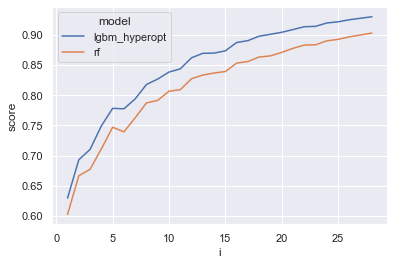

In [30]:
import seaborn as sns
sns.set()
sns.lineplot(data=pd.DataFrame(results), x='i', y='score', hue='model')

<AxesSubplot:xlabel='i', ylabel='score'>

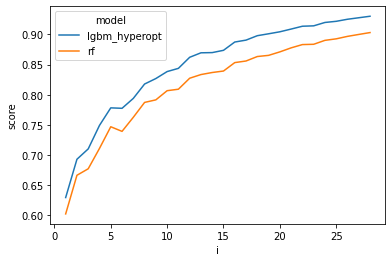

In [29]:
import seaborn as sns
sns.lineplot(data=pd.DataFrame(results), x='i', y='score', hue='model')

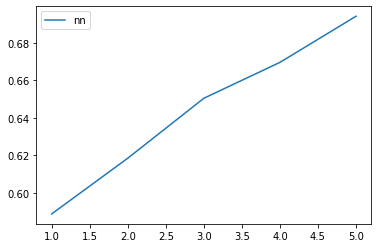

In [257]:
import matplotlib.pyplot as plt
# plt.plot(np.arange(1, 6), results, label='lgbm')
# plt.plot(np.arange(1, 6), results_imp, label='lgbm_imp')
# plt.plot(np.arange(1, 6), results_bagged, label='lgbm_bagged')
plt.plot(np.arange(1, 6), results_nn, label='nn')
# plt.plot(np.arange(1, 6), results_rf, label='rf')
plt.legend()

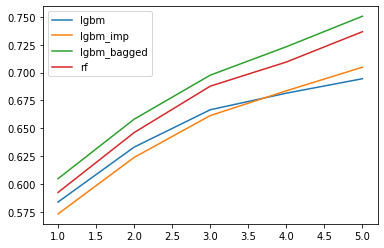

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, 6), results, label='lgbm')
plt.plot(np.arange(1, 6), results_imp, label='lgbm_imp')
plt.plot(np.arange(1, 6), results_bagged, label='lgbm_bagged')
plt.plot(np.arange(1, 6), results_rf, label='rf')
plt.legend()

In [113]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2299.998
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4599.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [33]:
y_test.loc[test_for_n[3].index]

ID
1      1
2      1
3      1
4      1
5      1
      ..
484    0
485    0
486    0
487    0
488    0
Name: PCR Result, Length: 488000, dtype: int64

In [32]:
y_test

ID
1      1
2      1
3      1
4      1
5      1
      ..
484    0
485    0
486    0
487    0
488    0
Name: PCR Result, Length: 488, dtype: int64

In [87]:
combinations = np.array(list(combinations(test.columns, i))))

TypeError: ignored

In [73]:
len(split_data(test)[0].columns)

30

In [29]:
!pip install optuna

     |████████████████████████████████| 296kB 3.9MB/s 
     |████████████████████████████████| 174kB 14.9MB/s 
     |████████████████████████████████| 81kB 8.1MB/s 
     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 143kB 18.3MB/s 
     |████████████████████████████████| 112kB 18.8MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=5e2d4737f0398bf28cbe61c94c2595bdbf3f094b3ca170bd338b20061609b8af
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [9]:
from sklearn.metrics import roc_auc_score

In [11]:
clf.predict(*split_data(test[train.columns]))

ValueError: ignored

In [33]:
split_data(test[train.columns])

(     Age Sex     AF   ALAT  ASAT  BILD  ...   MCV    MG     NA  PCAL   TRMB    UR
 ID                                      ...                                      
 1     63   M   78.0   23.0  22.0   5.0  ...  94.0  0.80  138.0  0.03  232.0   5.7
 2     54   M   67.0   40.0  37.0   3.0  ...  87.0  0.75  143.0  0.06  274.0   4.1
 3     47   F   65.0  172.0   NaN   4.0  ...  84.0  0.85  137.0  0.16  273.0   2.1
 4     56   F    NaN    NaN   NaN   1.0  ...  91.0   NaN  134.0  0.06  319.0   3.2
 5     58   M   61.0   17.0  23.0   4.0  ...  92.0  0.73  139.0  0.05  311.0   5.5
 ..   ...  ..    ...    ...   ...   ...  ...   ...   ...    ...   ...    ...   ...
 484   68   F  189.0    9.0  13.0   4.0  ...  95.0  0.78  137.0   NaN  291.0  12.0
 485   84   M   69.0   18.0  19.0   2.0  ...  93.0  0.80  134.0  0.05  430.0   5.8
 486   89   M   87.0   21.0  45.0   6.0  ...  90.0  0.73  134.0  0.47  238.0  10.9
 487   79   M   51.0   17.0  18.0   3.0  ...  95.0  0.83  131.0  0.01  221.0   4.2
 488

In [35]:
!pip install --upgrade lightgbm

     |████████████████████████████████| 2.0MB 3.8MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


(0.5, 1.0)

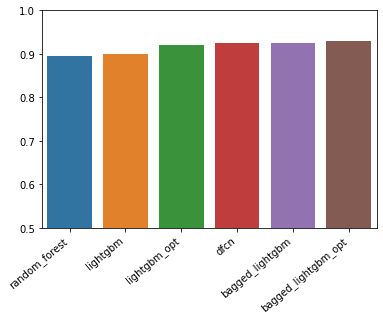

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
sns.barplot(x=['bagged_lightgbm_opt', 'bagged_lightgbm', 'lightgbm_opt', 'lightgbm', 'random_forest', 'dfcn'], 
            y=[0.9299631936085963, 0.9253580337362849, 0.919828353132032, 0.8993667905175572, 0.8957384827393724, 0.924], 
           order=np.array(['bagged_lightgbm_opt', 'bagged_lightgbm', 'lightgbm_opt', 'lightgbm', 'random_forest', 'dfcn'])[np.argsort([0.9299631936085963, 0.9253580337362849, 0.919828353132032, 0.8993667905175572, 0.8957384827393724, 0.924])])
plt.xticks(rotation=40, ha='right')
plt.ylim(0.5, 1.0)

In [30]:
results = pd.DataFrame({'name': ['bagged_lightgbm_opt', 'bagged_lightgbm', 'lightgbm_opt', 'lightgbm', 'random_forest', 'dfcn'], 'auc': [0.9299631936085963, 0.9253580337362849, 0.919828353132032, 0.8993667905175572, 0.8957384827393724, 0.924]})
results

,name,auc
0,bagged_lightgbm_opt,0.929963
1,bagged_lightgbm,0.925358
2,lightgbm_opt,0.919828
3,lightgbm,0.899367
4,random_forest,0.895738
5,dfcn,0.924000
